# Cross Validation

Chris Reger
Credit to J. Bennetto, D. Rupp

## Objectives

By the end of the day you should be able to

 * Describe the three kinds of model error
 * State the two ways cross validation is used
 * Explain k-fold cross validation
 * Explain the training, validation, testing data sets

## Agenda

In this lesson we will talk about

* A simple example
* Bias and Variance
* Train-test split
* K-fold cross validation

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

plt.style.use('ggplot')

## Bias Variance (From this morning)

In [2]:
cars = pd.read_csv('cars.csv', na_values=['?']) #Load data
cars = cars[cars.horsepower.notnull()]

In [3]:
def plot_from_this_morning(cars):
    X = cars.horsepower.values
    y = cars.mpg.values

    fig, axs = plt.subplots(2,3,figsize=(14, 8))
    x_tick = np.linspace(50,225,150)
    k_num = [1,3,5,10,15,50]

    for k, ax in zip(k_num,axs.flatten()):
        model = KNeighborsRegressor(k)
        model.fit(X.reshape(-1,1),y.reshape(-1,1))
        ax.scatter(X,y,c='blue')
        ax.plot(x_tick, model.predict(x_tick.reshape(-1,1)), linewidth=4)
        ax.set_xlabel('Horse Power')
        ax.set_ylabel('MPG')
        ax.set_title('Horse Power vs MPG with K={}'.format(k))

    fig.tight_layout()

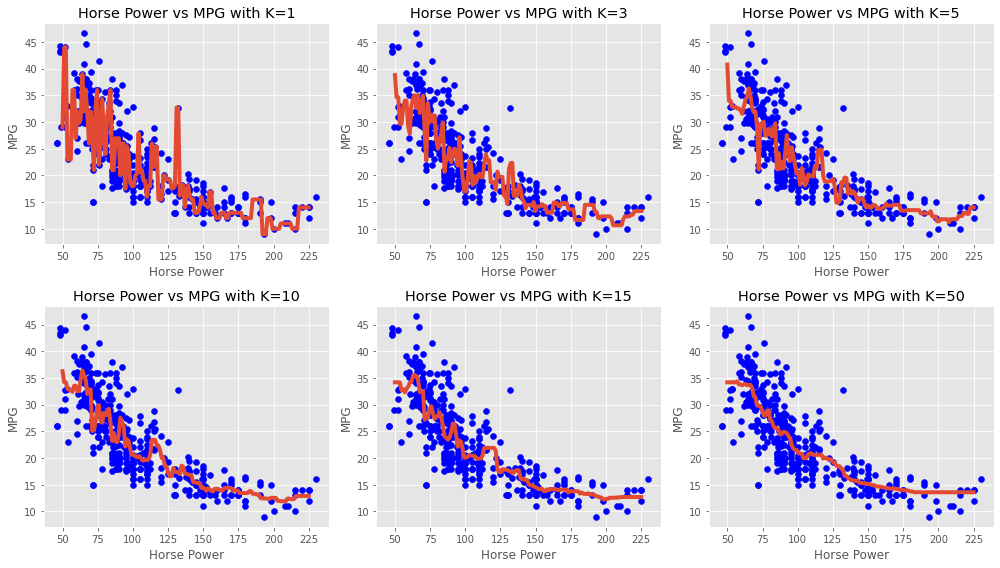

In [4]:
plot_from_this_morning(cars)

In [5]:
def plt_samples_given_k(axs, cars, k):
    
    x_tick = np.linspace(50,225,150)

    for samp, ax in enumerate(axs.flatten()):
        c = cars.sample(100)
        X = c.horsepower.values
        y = c.mpg.values
        model = KNeighborsRegressor(k)
        model.fit(X.reshape(-1,1),y.reshape(-1,1))
        ax.scatter(X,y,c='blue')
        ax.plot(x_tick, model.predict(x_tick.reshape(-1,1)), linewidth=4)
        ax.set_xlabel('Horse Power')
        ax.set_ylabel('MPG')
        ax.set_title('Sample {} Horse Power vs MPG with K={}'.format(samp,k))

    fig.tight_layout()

## How much does our model depend on the data sampled?

Lets look at building models with different samples.

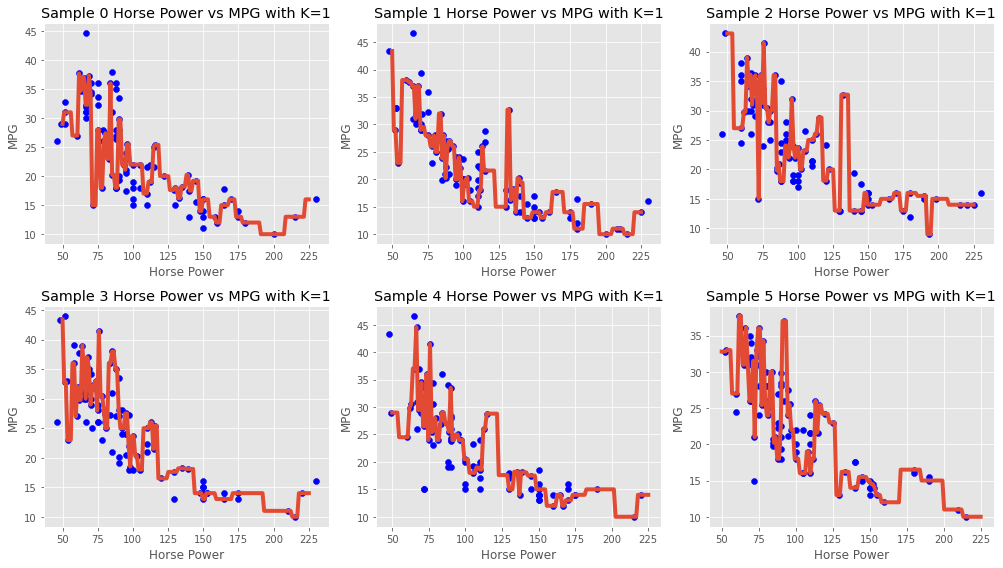

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt_samples_given_k(axs, cars, 1)

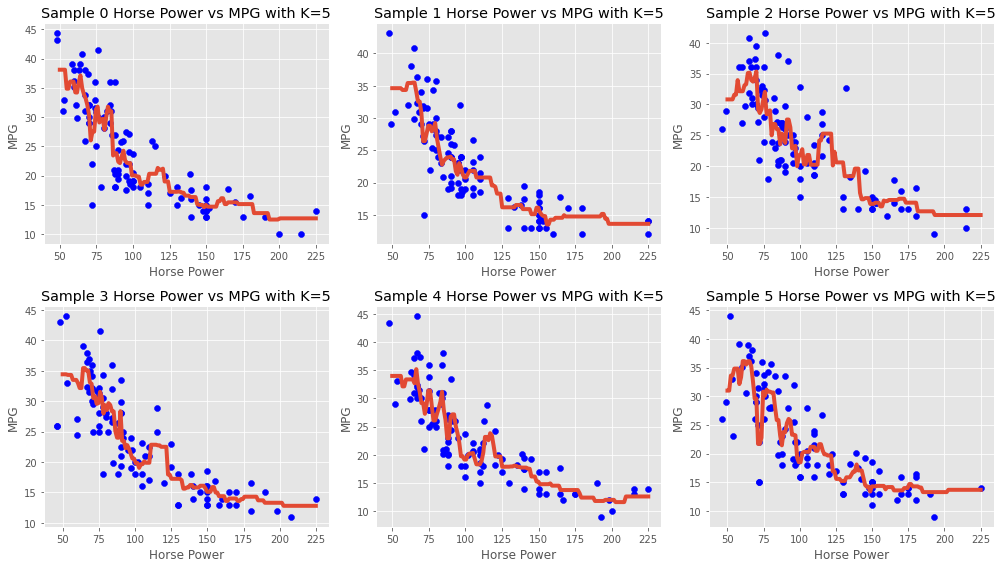

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt_samples_given_k(axs, cars, 5)

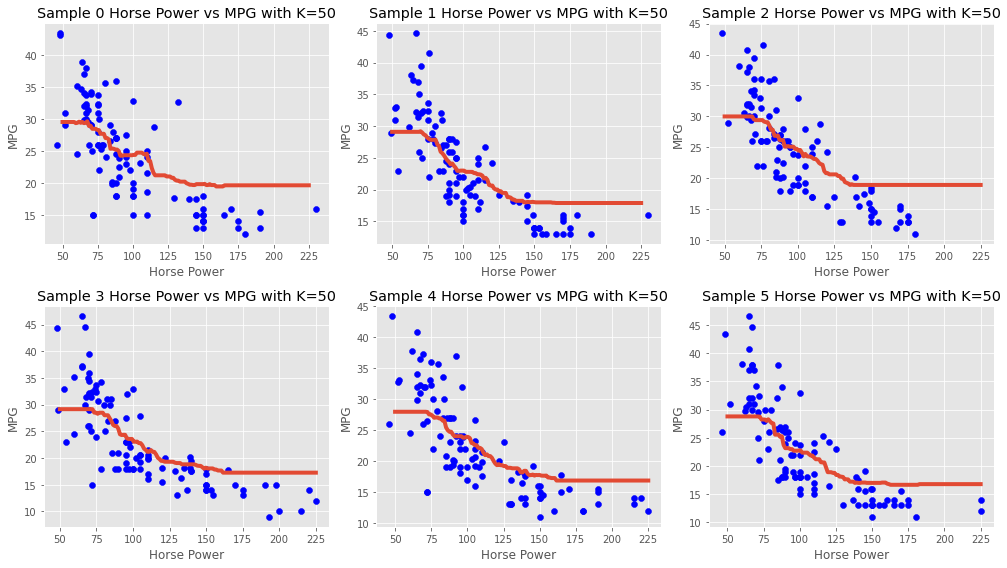

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt_samples_given_k(axs, cars, 50)

First, what we did is called **overfitting**, when we fit the specific available data in a way that doesn't generalize to other data. This happens pretty often, whenever we have a very complicated model with many independent parameters. Making our model too complicated is bad.

The opposite, called **underfitting**, is bad too. Suppose we'd just used the mean of the $y$ values to estimate $\hat y$ for all the points. That's too simple of a model.

### Bias and Variance

We'll come back to these again and again and again through the course. The mean-squared error of a model can be decomposed into three components.

<img src="img/bias_var.png">



Note that we don't ever actually know the values of these components, but they are useful in understanding how we make the best possible prediction.

1. The **irreducible error** is the error inherent in any value. Even if we had all possible data (the "population") and could build the best possible model, we can't predict values exactly.
2. The **bias** is the difference between the expected value of $y$ (averaging out the irreducible error) and the expected prediction of the model (that is, we had a large number of training datasets and we built a model using the same procedure on each one, and then averaged the predictions). If we predict the training set well we will generally have low bias.
3. The **variance** of the model over all possible training sets, which is a measure of how far the training-set model is from what it would be if trained on all the data. If we had access to entire population of data, we would have no variance.

Again, if we can't know these values, why do we care?

In general, there is a trade-off between bias and variance. A complex model might have very low bias, but will be highly dependent on the sample taken so will have high variance. A simple model might have higher bias, because it underfits, but lower variance, predicting other data nearly as well as the training sample.

Some models have **hyperparameters** that can be tuned. Most represent that trade-off: moving them in one direction will lower the bias and raise the variance; moving them in the other will do the opposite.

Every time you learn about a hyperparameter you should ask yourself if it represents a bias-variance trade-off, and which direction increases bias and decreases variance, and which direction does the opposite.

### Again, with math
$\DeclareMathOperator{\E}{\mathbb{E}}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\Var}{Var}$

Suppose there is some underlying true function $f(x)$, such that $y = f(x) + \epsilon$, where the noise $\epsilon$ has a mean of zero and standard deviation of $\sigma$. We've created some function $\hat f(x)$ to estimate $y$, and want $|y - \hat f(x)|$ to be as small as possible. We can decompose this into three parts: the  square of the **bias**, the **variance**, and the **irreducible error**.

$$\E\left[(y - \hat f(x))^2\right] = \left(\Bias[\hat f(x)]\right)^2 + \Var[\hat f(x)] + \sigma^2$$





I'm not going to go through the derivation; you can find in elsewhere (e.g. [wikipedia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation)). Instead I'll cover we'll look at an example.

<img src="img/bias_var.png">

### Bias and variance example

Let's see what that looks like with some fake data. Our true function $f$ will be a cosine curve; we'll add some noise to give values for $y$.

In [58]:
sigma = 1

def f(x): #True function
    return np.cos(x)

def y(x): #True function + Noise
    return f(x) + stats.norm(0, sigma).rvs(len(x))

In [59]:
xlim = (0, 10)
n_pts = 100
xpts = np.linspace(*xlim, n_pts)
ypts = f(xpts)

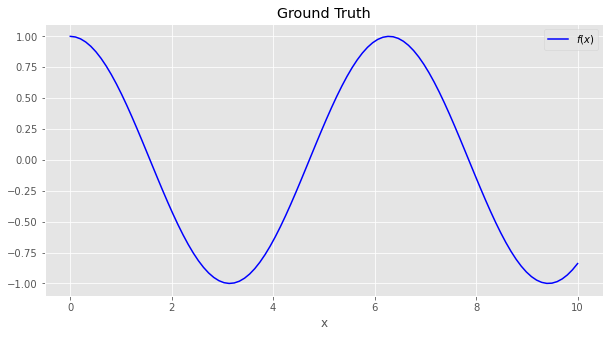

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xpts, ypts, 'b-', label='$f(x)$')
ax.legend()
ax.set_xlabel('x')
ax.set_title('Ground Truth');

Now we'll choose a training sample and fit a model to those data. We'll use a kNN regressor, since that's a simple model that we've already learned. We'll start with `k=3`.

In [61]:
sample_size = 20
sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(sample_size)
y_sample = y(sample)
model = KNeighborsRegressor(3)
model.fit(sample[:, None], y_sample)

KNeighborsRegressor(n_neighbors=3)

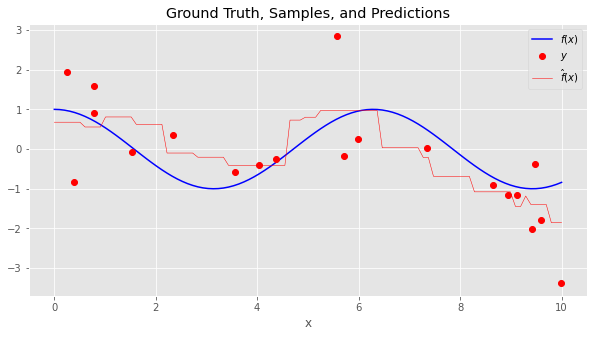

In [62]:
points = ax.plot(sample, y_sample, 'ro', label='$y$')
ax.plot(xpts, model.predict(xpts[:, None]), 'r-', lw=0.5, label='$\hat{f}(x)$')
ax.legend()
ax.set_title('Ground Truth, Samples, and Predictions')
fig

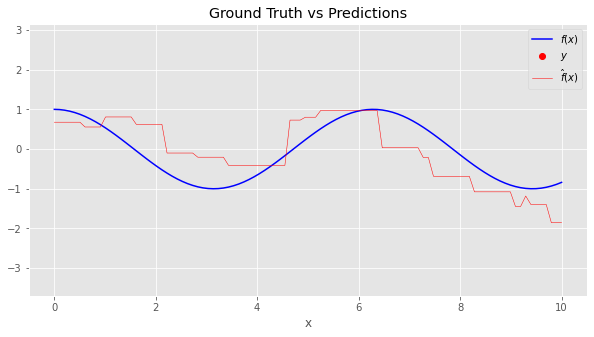

In [63]:
points[0].remove()
ax.set_title('Ground Truth vs Predictions')
fig

But to make sense of bias and variance, we need to consider a large number of training samples, and build a model for each. In reality we only have our one training sample, but we're doing this to try to understand the concept.

In [64]:
def plot_ks():
    fig, ax = plt.subplots(2, 4, figsize=(18,10), sharey='row', sharex='all')

    n_trials = 100
    sample_size = 50
    for i, k in enumerate((1, 3, 11, 25)):
        predictions = np.zeros((n_trials, n_pts))
        for t in range(n_trials):
            sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(sample_size)
            y_sample = y(sample)
            model = KNeighborsRegressor(k)
            model.fit(sample[:, None], y_sample)
            predictions[t, :] = model.predict(xpts[:, None])
            ax[0, i].plot(xpts, predictions[t,:], 'r-', lw=0.1)
        ax[0, i].plot(xpts, ypts, 'b-', label='$f(x)$')
        ax[0, i].plot(xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$E[\hat f(x)]$")

        ax[0, i].set_ylim((-2, 2))
        ax[0, i].set_title(f"k = {k}")
        ax[0, i].legend()
        #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
        bias = predictions.mean(axis=0) - ypts
        variance = predictions.var(axis=0)
        ax[1, i].plot(xpts, bias**2, 'k', label='bias^2')
        ax[1, i].plot(xpts, variance, 'r', label='variance')
        ax[1, i].plot(xpts, bias**2 + variance, 'g', label='total')
        ax[1, i].plot(xpts, np.zeros_like(xpts), 'k', lw=0.5)

        ax[1, i].legend()

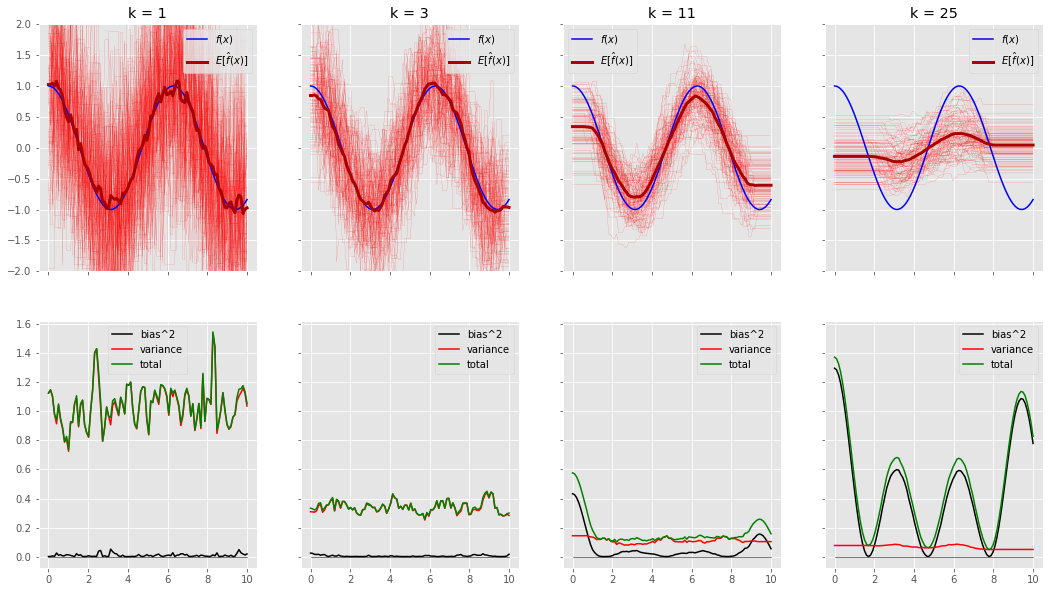

In [65]:
plot_ks()

Okay, so how do we tell which model is the best?

### CROSS VALIDATION!

The basic concept behind cross validation is the data on which we train our model can't accurately access its effectiveness. That's due to overfitting, that no matter how hard we try to generalize the model, its always based more on the data we used than the data we didn't.

<img src="img/800px-CRISP-DM_Process_Diagram.png" alt="Drawing" style="width: 400px;"/>

Cross validation really has two separate purposes.

First, it's used to **evaluate your model**. Part of the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) is evaluation; you (usually) need to know how well your model will predict real-world results. There are many ways to measure that, like mean-square-error or mean-absolute-error for regression models, or log loss or brier score or AUC/ROC or F-score some combination of precision and recall or sensitivity and specificity, based on your specific business case, but the key problem is that you can't measure it on your training data.


Second, it is used for **model comparison**. Over the coming week we'll learn a bunch of different models, and we need to evaluate which will do best for our data. In addition, many of these models have hyperparameters, and we need cross validation to choose the appropriate values, i.e., tuning the hyperparameters. 

Note: You can measure on your training data in some circumstances, either because your statistical measure allows some estimation of the error, or you have an ensemble model where different submodels see different data (out-of-bag error). But those aren't as general.

## The train-test split

The simplest approach we can use is the train-test split. You shouldn't call this cross validation, just say "train-test split" or "hold-out validation."

Let's start with the cars dataset that you may have seen before.

In [17]:
cars = pd.read_csv('cars.csv')


In [18]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


There are a few rows without data for horsepower, which is why it shows up as an object. We're just going to throw those away for now without worrying too much if that's okay.

In [19]:
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float128')
cars.mpg = cars.mpg.astype('float128')

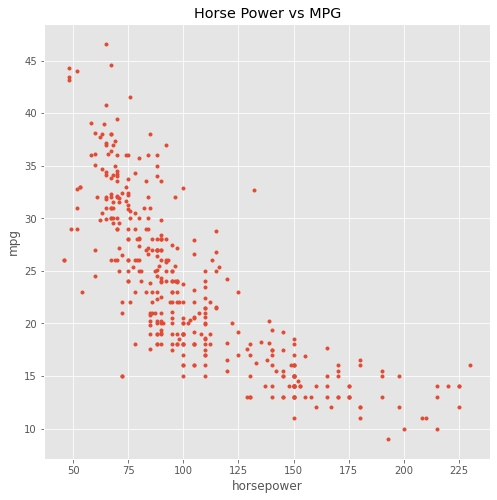

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cars.horsepower, cars.mpg, '.')
ax.set_title('Horse Power vs MPG')
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg");

In [21]:
X = cars[['horsepower']]
y = cars.mpg

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

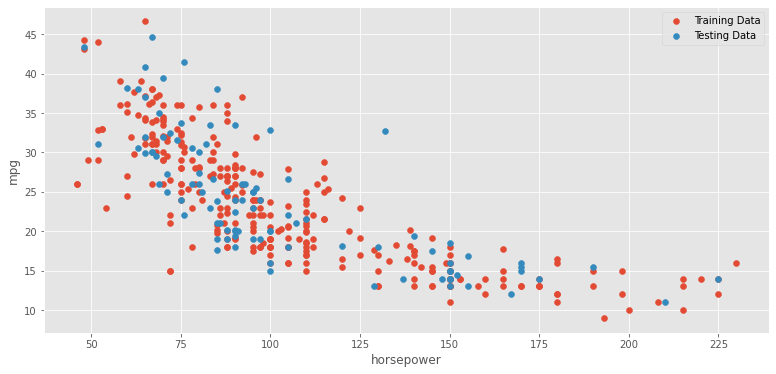

In [23]:
fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(X_train,y_train, label='Training Data')
ax.scatter(X_test,y_test, label='Testing Data')
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg")
ax.legend();

In [24]:
model = KNeighborsRegressor(20)
model.fit(X_train, y_train)
print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))
    
    
y_hat = model.predict(X_test)
#RMSE(y_hat, y_test)

R^2 on training data: 0.7429356517748182
R^2 on testing data:  0.6279908955823295


Okay, we did a bit better on the training data, as expected...or did we? Let's try a different random split.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = KNeighborsRegressor(20)
model.fit(X_train, y_train)
print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))

R^2 on training data: 0.7135171231035358
R^2 on testing data:  0.7155813292504436


Let's try fitting a lower $k$

What should this do?

R^2 on training data: 0.7231314687638914
R^2 on testing data:  0.6699572097630456


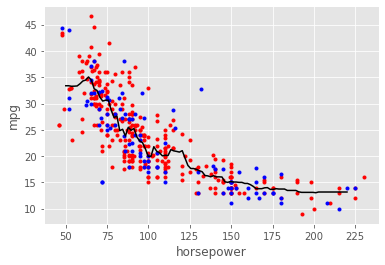

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

fig, ax = plt.subplots()
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg")
ax.plot(X_train, y_train, 'r.')
ax.plot(X_test, y_test, 'b.')


model = KNeighborsRegressor(15)
model.fit(X_train, y_train)
xpts = np.linspace(50, 220, 100).reshape(-1, 1)
ax.plot(xpts, model.predict(xpts), 'k-')

print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))

There's a graph you've probably seen showing the error in the training and test sets for different complexities. Let's see if we can reproduce it.

In [27]:
def mean_squared_error(model, X, y):
    return np.mean((model.predict(X) - y) **2)

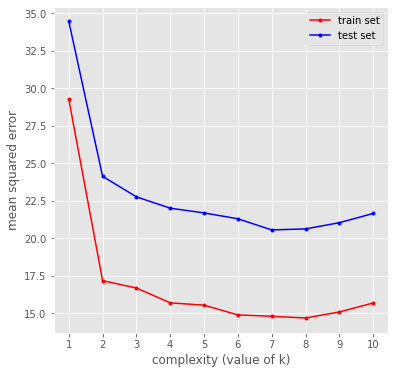

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

train_score = []
test_score = []

for k in range(1, 11):
    model = KNeighborsRegressor(k)
    model.fit(X_train, y_train)
    train_score.append(mean_squared_error(model, X_train, y_train))
    test_score.append(mean_squared_error(model, X_test, y_test))
    #train_score.append(-model.score(X_train, y_train))
    #test_score.append(-model.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1, 11), train_score, '.-r', label="train set")
ax.plot(range(1, 11), test_score, '.-b', label="test set")
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

That's great! So we do better with the training set than the test set for any complexity. We have a minimum value of around 7-8. Let's try some many more splits.

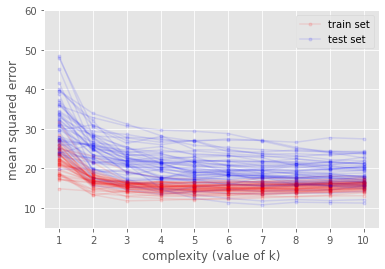

In [29]:
fig, ax = plt.subplots()

for t in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    train_score = []
    test_score = []

    for k in range(1, 11):
        model = KNeighborsRegressor(k)
        model.fit(X_train, y_train)
        train_score.append(mean_squared_error(model, X_train, y_train))
        test_score.append(mean_squared_error(model, X_test, y_test))
        #train_score.append(-model.score(X_train, y_train))
        #test_score.append(-model.score(X_test, y_test))
    if t == 0:
        ax.plot(range(1, 11), train_score, 'r.-', label="train set", alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', label="test set", alpha=0.1)
    else:
        ax.plot(range(1, 11), train_score, 'r.-', alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', alpha=0.1)
        
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
ax.set_ylim(5, 60)
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

Overall, this isn't all that consistent. We need something better.

## K-fold Cross Validation

With Cross Validation, we randomly partition the data into $k$ groups, $D_1$, $D_2$, ..., $D_k$. For each $i \in [1..k]$ we:

 * Build a model using $D_{j \ne i}$ as a training data
 * Calculate the error of the model on $D_i$
 
We average all these errors to compute the overall error of the model. We can either compare those across different models to choose the best model or use that number to report the actual error of our model.

There isn't a clear "best" value for $k$. The extreme version of k-fold cross validation, when $k=n$, is called leave-one-out cross validation. That's generally not so good, and $k=2$ is not so good, but experience has shown that other choices are fine. I like $k=5$.

So suppose we have fifteen data points (labeled a...o) and we're doing 5-fold cross validation. We'll put the 1st three in the first fold, the next three in the next fold, and so on.

We would build 5 different models (one for each split column, below) using the "train" data points, test each on the "TEST" data points, and average the results.

data point | fold | 1st split  | 2nd split | 3rd split | 4th split | 5th split
---|---|---|---|---|---|---
 a | 1 | **test** | train | train | train | train | 
 b | 1 | **test** | train | train | train | train | 
 c | 1 | **test** | train | train | train | train | 
 d | 2 | train | **test** | train | train | train | 
 e | 2 | train | **test** | train | train | train | 
 f | 2 | train | **test** | train | train | train | 
 g | 3 | train | train | **test** | train | train | 
 h | 3 | train | train | **test** | train | train | 
 i | 3 | train | train | **test** | train | train | 
 j | 4 | train | train | train | **test** | train | 
 k | 4 | train | train | train | **test** | train | 
 l | 4 | train | train | train | **test** | train | 
 m | 5 | train | train | train | train | **test** | 
 n | 5 | train | train | train | train | **test** | 
 o | 5 | train | train | train | train | **test** | 

**Question:** Generally we shuffle the data points first. Why?

We could write code to do this, but `sklearn` has already done that. One confusing thing about the `KFold` object in `sklearn` is that it returns indices, not the data themselves. Here's how we use it.

In [30]:
kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
fold_scores = []

for train, test in kf.split(X_train):
    model = KNeighborsRegressor(10)
    model.fit(X_train.values[train], y_train.values[train])
    fold_scores.append(model.score(X_train.values[test], y_train.values[test]))
    
print(np.mean(fold_scores))

0.6840000415234792


Will this give more consistent results than the train-test split? Let's do the same error-vs-complexity graph using 5-fold cross validation.

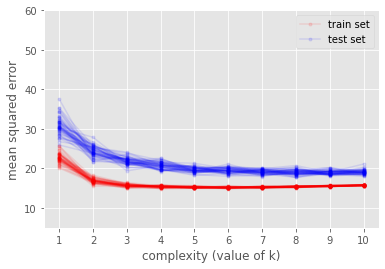

In [31]:
fig, ax = plt.subplots()

for t in range(50):
    kf = KFold(n_splits=5, shuffle=True)
    scores = []

    train_score = []
    test_score = []

    for k in range(1, 11):
        train_fold_scores = []
        test_fold_scores = []

        for train, test in kf.split(X):
            model = KNeighborsRegressor(k)
            model.fit(X.values[train], y.values[train])
            train_fold_scores.append(mean_squared_error(model, X.values[train], y.values[train]))
            test_fold_scores.append(mean_squared_error(model, X.values[test], y.values[test]))

        train_score.append(np.mean(train_fold_scores))
        test_score.append(np.mean(test_fold_scores))
        #train_score.append(-model.score(X_train, y_train))
        #test_score.append(-model.score(X_test, y_test))
    if t == 0:
        ax.plot(range(1, 11), train_score, 'r.-', label="train set", alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', label="test set", alpha=0.1)
    else:
        ax.plot(range(1, 11), train_score, 'r.-', alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', alpha=0.1)
        
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
ax.set_ylim(5, 60)
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

A couple other notes.

Many `sklearn` models include "CV" versions that use cross validation to calculate hyperparameters automatically.

**Stratified cross validation** is a variation in which the partitions are chosen to have similar distributions of labels.

## Overfitting on the testing data

There's a problem with all this. Because the model and hyperparameters are chosen based on the training and testing data, the errors of the model aren't an accurate representation of how it would behave on outside data. If we want to know how it will behave in general, we need to hold out additional data. In this case we have

 * **Training data** are used to fit the model.
 * **Validation data** are used to choose the model and hyperparameters. Once these are determined, these are combined with the training data to re-fit the model.
 * **Testing data** are used to evaluate the final accuracy of the model.
 
For each of these we can use either simple hold-out validation or k-fold cross validation.

<img src="img/train_val_test.png">

We do this to:   
 * Compare different models
 * Compare models with different parameters (for kNN think `k` and the distance metric)
 * Compare models with different features

# What to do if your model is overfitting

Pretty common.  If you are starting with 5-10 features that can already be pretty complex.  

1. Get more data...  (not usually possible/practical but almost always the easy answer)
2. Subset Selection: keep only a subset of your predictors (ie, dimensions)
3. Regularization: restrict your models parameter space (Wednesday)
4. Dimensionality Reduction: project the data into a lower dimensional space (later in course)

# Subset Selection:

The features you select to put into your model will dictate how well you model preforms.  As this is a important idea what ways can we try different features?   

   
What if we try every combination of features and find the best score?


### Best subset:
- Try every combination of `p` predictors
 * Computationally intensive.  

## Stepwise:
- Iteratively pick predictors to be in/out of the final model.

## Forward Stepwise Selection   
    
 1. Create a model for every feature on its own.  Choose the feature with the best score.   
 2. Run model with 2 features, best feature and every other feature.  Choose model features that have best score.   
 3. Continue adding features until increase of score becomes not worth extra features or you run out of features.   
 
   
I this better then just trying all combinations?   
   
Why may this not be good?
 <img src="img/step_forward.png">

## Review:
 * What is bias
 * What is variance 
 * What is a test train split
 * Why do we do a test train split
 * What can we control to improve a kNN model
 
 


<img src="img/target.png">